## Hydropower Dam Data Exploration

In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import math

In [2]:
# Load the data
metadata = pd.read_csv('../data/metafile_1026.csv', index_col=0, header=None, names=['feature', 'description'])
data = pd.read_csv('../data/global_dams_db_1026.csv')

In [3]:
# Check the number of dams/features
data.shape

(7319, 77)

In [4]:
# Look at the names of the features. Below are the names of the benefit/impact metrics 
# based on Rafa's email:
#      - GEN_GWH_YR - Gigawatts generated per year
#      - RES_BAL - Fisheries change in tonnes of fish per year
#      - CO2EQ_total - Total CO2 emmisions for the dam in g/m^2.year
data.columns

Index(['GRAND_ID', 'DAM_NAME', 'MAIN_BASIN', 'SUB_BASIN', 'NEAR_CITY',
       'COUNTRY', 'SEC_CNTRY', 'YEAR', 'REM_YEAR', 'DAM_HGT_M', 'DAM_LEN_M',
       'AREA_SKM', 'CAP_MCM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL',
       'CATCH_SKM', 'USE_IRRI', 'USE_ELEC', 'USE_SUPP', 'USE_FCON', 'USE_RECR',
       'USE_NAVI', 'USE_FISH', 'USE_PCON', 'USE_LIVE', 'USE_OTHR', 'MAIN_USE',
       'LAKE_CTRL', 'LONG_DD', 'LAT_DD', 'COUNTRY_1', 'GDP_capita',
       'Population', 'RES_YLD_TN', 'RES_LSS_TN', 'RES_BAL', 'FISH_RATIO',
       'CO2EQ_areal', 'CO2EQ_total', 'INSCAP_MW', 'pred_INSCAP_MW',
       'GEN_GWH_YR', 'pred_GEN_GWH_YR', 'run_mm_syr', 'inu_pc_umn',
       'sgr_dk_sav', 'clz_cl_smj', 'ari_ix_sav', 'ari_ix_uav', 'glc_cl_smj',
       'pnv_cl_smj', 'wet_cl_smj', 'for_pc_use', 'crp_pc_use', 'pst_pc_use',
       'ire_pc_use', 'gla_pc_use', 'prm_pc_use', 'pac_pc_use', 'fmh_cl_smj',
       'soc_th_uav', 'swc_pc_uyr', 'lit_cl_smj', 'ero_kh_uav', 'pop_ct_usu',
       'ppd_pk_uav', 'urb_pc_

In [5]:
# Print the number of dams that have data on each metric
for column in ['GEN_GWH_YR', 'RES_BAL', 'CO2EQ_total']:
    print("{}: {} dams".format(column, data.shape[0] - data[column].isna().sum()))

GEN_GWH_YR: 477 dams
RES_BAL: 5898 dams
CO2EQ_total: 4813 dams


In [6]:
data_filt = data

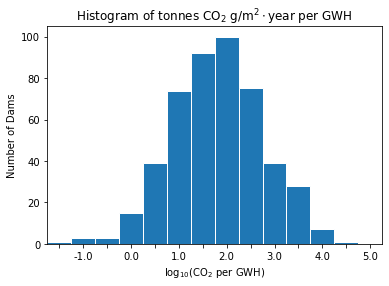

In [80]:
# Plot a histogram of CO2/GWH.yr by order of magnitude
plt.hist(np.log10(data_filt['CO2_total_per_GWH']), bins=np.arange(-2,5.5,0.5), linewidth=1, edgecolor='w')
plt.xlabel('$\log_{10}$(CO$_2$ per GWH)')
bins = np.arange(-2,5.5,0.5)
plt.xticks(ticks=np.arange(-2,5.5,0.5) - 0.25, labels=[bins[i] if i%2 == 0 else '' for i in range(len(bins))])
plt.ylabel('Number of Dams')
plt.xlim([-2, 5])
plt.title('Histogram of tonnes CO$_2$ g/m$^2 \cdot$year per GWH')
plt.show()

In [9]:
# Add a column for the signed log of change in fish. i.e. the log of the magnitude times the sign
data_filt['fish_per_GWH_rounded'] = data_filt['fish_per_GWH'].apply(lambda x: np.sign(x)*np.ceil(np.abs(x)))
data_filt['signed_log_fish_per_GWH'] = data_filt['fish_per_GWH_rounded'].apply(lambda x: np.sign(x)*np.log(np.abs(x)))

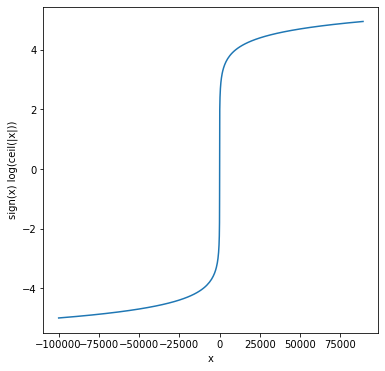

In [77]:
ys = np.arange(-5,5,0.05)
xs = [np.sign(x)*10**(np.abs(x)) for x in ys]

plt.figure(figsize=(6,6))
plt.plot(xs,ys)
plt.xlabel('x')
plt.ylabel('sign(x) log(ceil(|x|))')
plt.show()

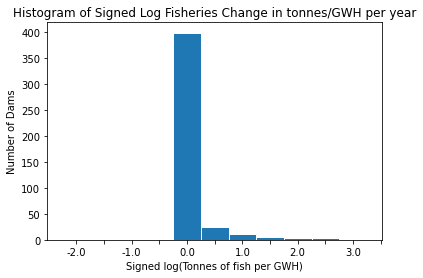

In [81]:
# Plot a histogram of fisheries change in tonnes /m^2.yr by order of magnitude
plt.hist(data_filt['signed_log_fish_per_GWH'], np.arange(-2,4,0.5), linewidth=1, edgecolor='w')
plt.xlabel('Signed log(Tonnes of fish per GWH)')
bins = np.arange(-2,4,0.5)
plt.xticks(ticks=np.arange(-2,4,0.5) + 0.25, labels=[bins[i] if i%2 == 0 else '' for i in range(len(bins))])
plt.ylabel('Number of Dams')
plt.title('Histogram of Signed Log Fisheries Change in tonnes/GWH per year')
plt.show()

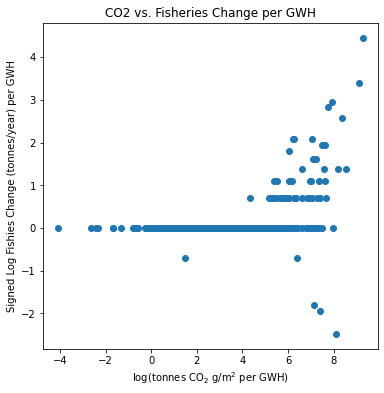

In [82]:
# Plot the log scale fisheries gain versus CO2 emissions
fig = plt.figure(figsize=(6,6))
plt.scatter(np.log(data_filt['CO2_total_per_GWH']), data_filt['signed_log_fish_per_GWH'])
plt.xlabel('log(tonnes CO$_2$ g/m$^2$ per GWH)')
plt.ylabel('Signed Log Fishies Change (tonnes/year) per GWH')
plt.title('CO2 vs. Fisheries Change per GWH')
plt.show()

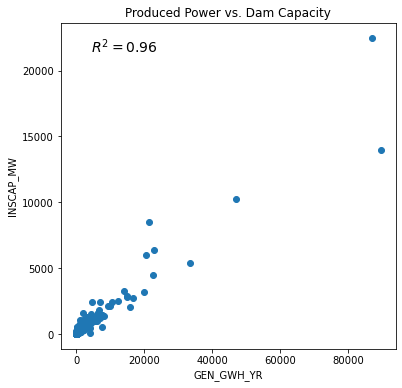

In [84]:
# Compare dam capacity (i.e. potential power generation) and generated GWH/yr
# to get an idea of whether we could use capacity as a proxy
fig = plt.figure(figsize=(6,6))
plt.scatter(data['GEN_GWH_YR'], data['INSCAP_MW'])
plt.xlabel('GEN_GWH_YR')
plt.ylabel('INSCAP_MW')
plt.title('Produced Power vs. Dam Capacity')

filt = data.apply(lambda x: not (math.isnan(x['INSCAP_MW']) | math.isnan(x['GEN_GWH_YR'])), axis=1)
x_range = max(data['GEN_GWH_YR'][filt]) - min(data['GEN_GWH_YR'][filt])
y_range = max(data['INSCAP_MW'][filt]) - min(data['INSCAP_MW'][filt])
r2 = pearsonr(data['GEN_GWH_YR'][filt], data['INSCAP_MW'][filt])

plt.text(0.05*x_range , 0.95*y_range, '$R^2 = {:0.2f}$'.format(pearsonr(data['GEN_GWH_YR'][filt], data['INSCAP_MW'][filt])[0]),
        fontweight='bold', fontsize='14')
plt.show()

### Look for Highly Correlated Features

In [15]:
# Delare a vector of features we will use for the regression. 
# Note that this does not include categorical features, but that we can also use those using one-hot encoding.
# categorial_features = ['clz_cl_smj', 'glc_cl_smj', 'pnv_cl_smj', 'wet_cl_smj', 
#                        'fmh_cl_smj', 'lit_cl_smj', 'MAIN_USE', 'LAKE_CTRL']

features = ['DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM', 
            'GDP_capita', 'Population', 'run_mm_syr', 'inu_pc_umn', 'sgr_dk_sav', 'ari_ix_sav', 'ari_ix_uav', 
            'for_pc_use', 'crp_pc_use', 'pst_pc_use', 'ire_pc_use', 'gla_pc_use', 'prm_pc_use', 'pac_pc_use', 
            'soc_th_uav', 'swc_pc_uyr', 'ero_kh_uav', 'pop_ct_usu', 'ppd_pk_uav', 'urb_pc_use', 'hft_ix_u09', 
            'hdi_ix_sav', 'YEAR', 'CAP_MCM', 'RES_YLD_TN', 'RES_LSS_TN', 'CO2_total_per_GWH',
            'fish_per_GWH', 'capacity_factor']

In [16]:
# Look for highly correlated features
cor = data.corr()
cor_table = cor.stack().reset_index().rename(columns={'level_0':'feature_1','level_1':'feature_2', 0:'cor'})
cor_table = cor_table[(cor_table.feature_1 > cor_table.feature_2)]

thresh = 0.8
filt_table = cor_table[(cor_table.cor > thresh) | (cor_table.cor < -thresh)]
filt_table.sort_values(by='cor', ascending=False)

,feature_1,feature_2,cor
1265,pred_INSCAP_MW,REM_YEAR,1.000000
1369,pred_GEN_GWH_YR,REM_YEAR,1.000000
1285,pred_INSCAP_MW,pred_GEN_GWH_YR,1.000000
935,RES_LSS_TN,RES_BAL,0.994301
3248,fish_per_GWH_rounded,fish_per_GWH,0.993379
1229,INSCAP_MW,GEN_GWH_YR,0.960937
1735,ari_ix_uav,ari_ix_sav,0.928361
1445,run_mm_syr,ari_ix_sav,0.873897
2878,hdi_ix_sav,GDP_capita,0.853299
1446,run_mm_syr,ari_ix_uav,0.846017


### Explore Cummulative Totals for CO2/Fish

In [17]:
# Create cummulative totals over power and GHG emissions
data_filt = data_filt.sort_values(by='CO2_total_per_GWH')
data_filt['CO2_cumsum'] = (data_filt['CO2EQ_total']).cumsum()
data_filt['CO2_GWH_cumsum'] = data_filt['GEN_GWH_YR'].cumsum()
data_filt['CO2_cumavg'] = data_filt.apply(lambda x: x['CO2_cumsum']/(x['CO2_GWH_cumsum']), axis=1)

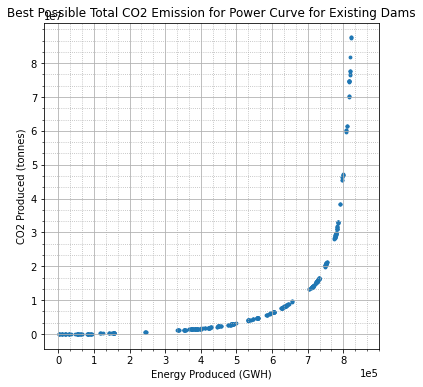

In [18]:
# Create a plot of cummulative sum versus rank by percentile for the CO2 values
fig = plt.figure(figsize=(6,6))
plt.scatter(data_filt['CO2_GWH_cumsum'], data_filt['CO2_cumsum'], s=8)

# Format axes
plt.xticks(np.arange(0,9*10**5,10**5))
plt.yticks(np.arange(0,9*10**7,10**7))
ax = plt.gca()
ax.set_xticks(np.arange(0,9*10**5,1/3*10**5), minor=True)
ax.set_yticks(np.arange(0,9*10**7,1/3*10**7), minor=True)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')

plt.xlabel('Energy Produced (GWH)')
plt.ylabel('CO2 Produced (tonnes)')
plt.title('Best Possible Total CO2 Emission for Power Curve for Existing Dams')

plt.show()

In [19]:
# Create cummulative totals over power and GHG emissions
data_filt = data_filt.sort_values(by='fish_per_GWH', ascending=False)
data_filt['fish_cumsum'] = (data_filt['RES_BAL']).cumsum()
data_filt['fish_GWH_cumsum'] = data_filt['GEN_GWH_YR'].cumsum()
data_filt['fish_cumavg'] = data_filt.apply(lambda x: x['fish_cumsum']/(x['fish_GWH_cumsum']), axis=1)

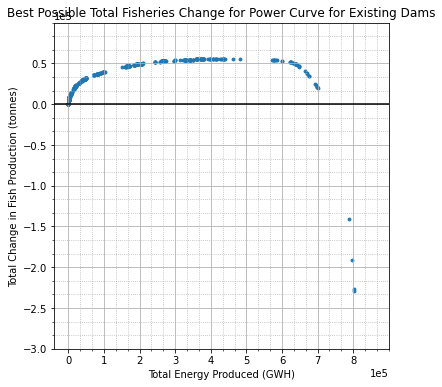

In [20]:
# Create a plot of cummulative sum versus rank by percentile for the CO2 values
fig = plt.figure(figsize=(6,6))
plt.scatter(data_filt['fish_GWH_cumsum'], data_filt['fish_cumsum'], s=8)

# Format axes
plt.xticks(np.arange(0,9*10**5,10**5))
plt.yticks(np.arange(-3*10**5,1*10**5,0.5*10**5))
ax = plt.gca()
ax.set_xticks(np.arange(0,9*10**5,1/3*10**5), minor=True)
ax.set_yticks(np.arange(-3*10**5,1*10**5,1/6*10**5), minor=True)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
plt.axhline(0, c='k')

plt.xlabel('Total Energy Produced (GWH)')
plt.ylabel('Total Change in Fish Production (tonnes)')
plt.title('Best Possible Total Fisheries Change for Power Curve for Existing Dams')

plt.show()